In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.light38_hparams import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Mon Mar  8 19:42:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.04    Driver Version: 455.23.04    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:19:00.0 Off |                  N/A |
| 67%   58C    P2   206W / 370W |   8157MiB / 24268MiB |     92%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:68:00.0 Off |                  N/A |
| 56%   

In [3]:
save_dir = 'save/light38_model'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [4]:
!ls $save_dir

data.json   save_15000	save_23857  save_25945	save_28747
save_0	    save_20000	save_24369  save_26318	save_28920
save_10000  save_204	save_24483  save_26446	save_2931
save_1007   save_23111	save_25000  save_27632	save_5000
save_13     save_23614	save_25005  save_28655	save_666


In [5]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=tts_hparams.lr, weight_decay=tts_hparams.weight_decay)

step = 28920

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"MelEncoder size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if True:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 162.3MiB
TTS size 156.0MiB
MelEncoder size 52.3MiB
MelDecoder size 94.9MiB
loaded : 28920
28920
done


In [6]:
trainset = LJDataset(tts_hparams)
collate_fn = TextMelCollate(tts_hparams)
train_loader = torch.utils.data.DataLoader(trainset, num_workers=tts_hparams.num_workers, 
                          shuffle=True,
                          sampler=None,
                          batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)

print(train_loader)

In [7]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

elapsed time : 0.01633613109588623


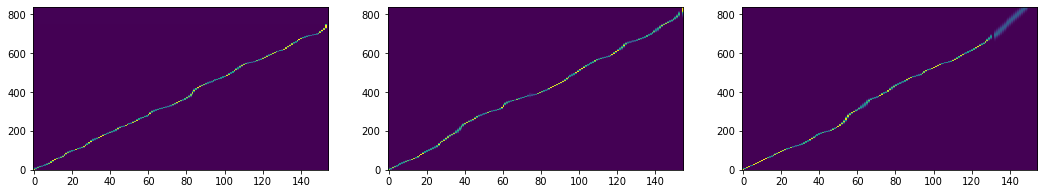

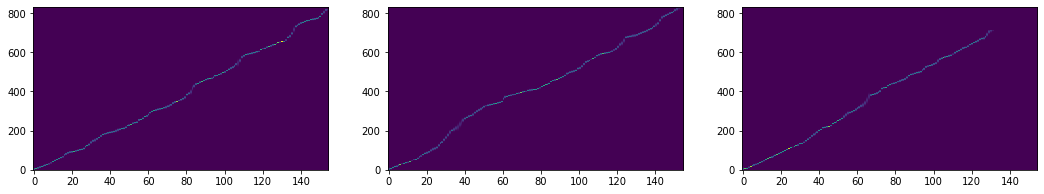

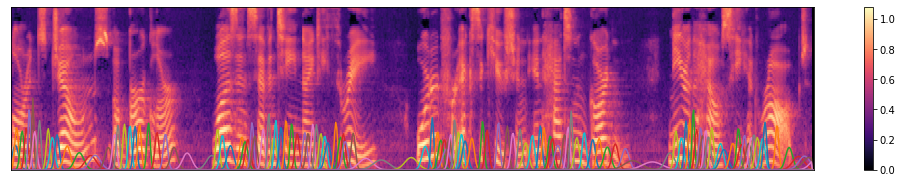

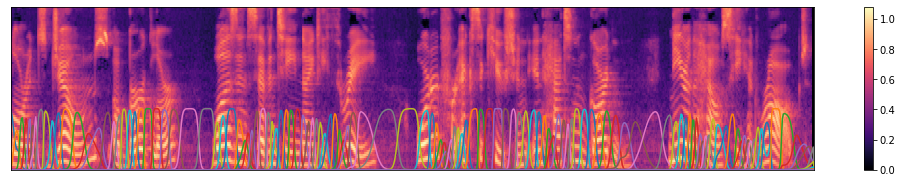

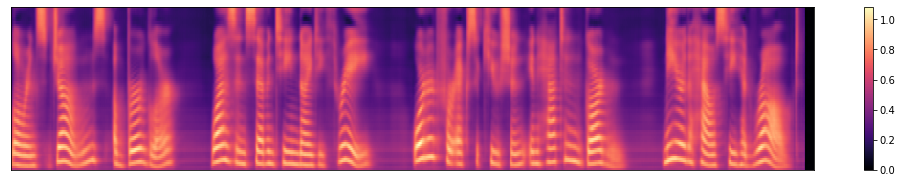

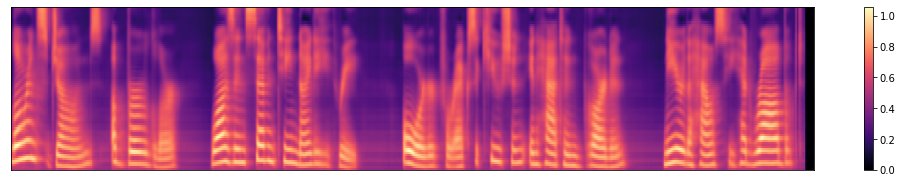

tensor(0.8301, device='cuda:0')
step : 30001 stt : 0.2075 tts : 0.0999 recon : 0.0031 kl : 0.0017 beta : 0.6008
tensor(0.6297, device='cuda:0')
step : 30002 stt : 0.2086 tts : 0.1003 recon : 0.0031 kl : 0.0017 beta : 0.6008
tensor(0.7738, device='cuda:0')
step : 30003 stt : 0.1956 tts : 0.0995 recon : 0.0031 kl : 0.0017 beta : 0.6008
tensor(1.0841, device='cuda:0')
step : 30004 stt : 0.1813 tts : 0.1043 recon : 0.0027 kl : 0.0016 beta : 0.6009
tensor(1.9020, device='cuda:0')
step : 30005 stt : 0.2031 tts : 0.1030 recon : 0.0027 kl : 0.0016 beta : 0.6009
tensor(0.8426, device='cuda:0')
step : 30006 stt : 0.1829 tts : 0.1065 recon : 0.0029 kl : 0.0017 beta : 0.6009
tensor(0.6180, device='cuda:0')
step : 30007 stt : 0.1694 tts : 0.0967 recon : 0.0030 kl : 0.0017 beta : 0.6009
tensor(0.5294, device='cuda:0')
step : 30008 stt : 0.1847 tts : 0.0965 recon : 0.0033 kl : 0.0018 beta : 0.6009
tensor(0.7445, device='cuda:0')
step : 30009 stt : 0.1833 tts : 0.1047 recon : 0.0029 kl : 0.0017 beta :

In [ ]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

model.train()

while(True):
    
    for batch in train_loader:
        batch = to_cuda(batch)
        
        model.train()
        model.increase_step()
        model.zero_grad()

        stt_outputs, tts_outputs = model(batch)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item(),
                  'beta :', '%0.4f' % model.beta.item())
                  
            
        if step % 100 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', model.beta.item())    
            
        if step % 100 == 0:
            display.clear_output()
            
            index = 3
            model.eval()
            
            with torch.no_grad():
                times = []
                for _ in range(10):
                    t0 = time.time()
                    samples, _ = model.inference(batch['text'], batch['mels'].size(2), tts_outputs["stt_alignments"], temperature=1.0)
                    t1 = time.time()
                    times.append(t1 - t0)
                times = np.array(times)
                print('elapsed time :', np.mean(times))

            _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
            batch_size = _tts_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
            batch_size = _stt_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _x = batch['mels'].data.cpu().numpy()
            librosa.display.specshow(_x[index])
            plt.colorbar()
            
            for i in range(_stt_alignments.shape[1]):
                plt.plot(_stt_alignments[index, i] * 100)
                
            plt.show()
            
            _stt_alignments = tts_outputs["stt_alignments"].data.cpu().numpy()
            plt.figure(figsize=[18, 3])
            _x = batch['mels'].data.cpu().numpy()
            librosa.display.specshow(_x[index])
            plt.colorbar()
            
            for i in range(_stt_alignments.shape[1]):
                plt.plot(_stt_alignments[index, i] * 30)
                
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _y = tts_outputs['pred'].data.cpu().numpy()
            librosa.display.specshow(np.maximum(_y[index], 0))
            plt.colorbar()
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _s = samples.data.cpu().numpy()
            librosa.display.specshow(np.maximum(_s[index, :, :_y.shape[2]], 0))
            plt.colorbar()
            plt.show()
                      
        step += 1
        

In [26]:
logger.save(step, model, optimizer)

saved save/light38_model/save_29147


['This is a definite advantage to the shooter, the vehicle moving directly away from him and the downgrade of the street, and he being in an elevated position', 'The selection of the Trade Mart as the possible site for the luncheon first appeared in the Dallas Times-Herald on November fifteen, nineteen sixty-three.', 'Wainwright was allowed a cigar the night before execution, which he smoked in the prison yard, walking up and down with the governor, Mr. Sydney Smith.', 'The merchant Wallace said he had been led into the crime by the advice and example of a city friend who had gone largely into this nefarious business;', '"to inquire into and report upon the several jails and houses of correction in the counties, cities, and corporate towns within England and Wales', "I was coming out this one on the second floor, and I don't know, I was kind of sweeping this area as I come up, I was looking from right to left", 'and suggests the possibility, as did his note to his wife just prior to th

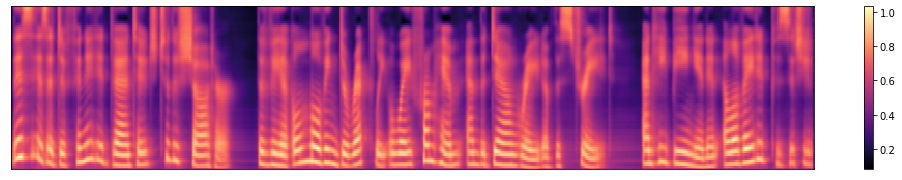

In [22]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 

for batch in train_loader:
    batch = to_cuda(batch)
    print(batch['strings'])
    break
        
model.eval()
with torch.no_grad():
    index = 0
    times = []
    for _ in range(10):
        t0 = time.time()
        samples, time_dict = model.inference(batch['text'][0:1], None, None, temperature=1.0)
        t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    print(samples.shape, np.mean(times))
    print(time_dict)
    
    plt.figure(figsize=[18, 3])
    _s = samples.data.cpu().numpy()
    librosa.display.specshow(_s[index])
    plt.colorbar()
    plt.show()

In [23]:
time_sum = 0
for key in time_dict.keys():
    time_sum += time_dict[key]

for key in time_dict.keys():
    print(key, '%0.2f' % (time_dict[key] / time_sum))


alignment 0.02
random 0.01
last_conv 0.36
z_proj 0.01
cond 0.05
up 0.06
encode 0.25
pad 0.00
enc_conv 0.06
enc_lstm 0.18


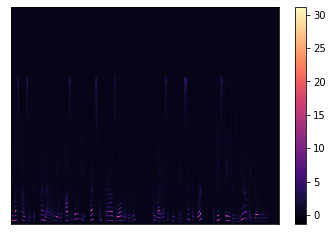

In [30]:
def denormalize(x):
    return np.exp(x * -np.log(1e-5) + np.log(1e-5))

import time

mel_matrix = librosa.filters.mel(sr=22050, n_fft=1024, n_mels=80, fmin=80, fmax=7600)
inv_matrix = np.linalg.pinv(mel_matrix)

mel = denormalize(_s[0])
spec = inv_matrix @ mel

librosa.display.specshow(spec)
plt.colorbar()
plt.show()

audio = librosa.griffinlim(spec, n_iter=32, hop_length=256, win_length=None, window='hann')
import IPython.display as ipd
ipd.Audio(audio, rate=22050)